In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MNIST dataset

## Fetching dataset from OpenML
70000 images, each 28x28 pixels (784 features)

In [ ]:
from sklearn.datasets import fetch_openml
# Three types of functions:
# - fetch_* - download real-time datasets
# - load_* - small bundled datasets
# - make_* - generate fake datasets (returns NumPy input-target tuples)
# Usually returns sklearn.utils.Bunch object with "DESCR", "data" and "target"

# Returns Pandas objects by default (not ideal for images)
mnist = fetch_openml('mnist_784', as_frame=False)

In [ ]:
X = mnist.data
y = mnist.target

print(str.format("Data - {}:", X.shape))
print(X)
print()
print(str.format("Target - {}:", y.shape))
print(y)
print()
print(str.format("Categories: {}", mnist.categories['class']))

Data - (70000, 784):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Target - (70000,):
['5' '0' '4' ... '4' '5' '6']

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Visualize images

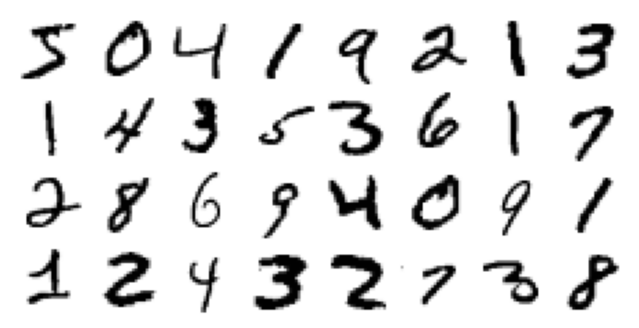

In [ ]:
def plot_digit(digit_data):
  image = digit_data.reshape(28, 28)
  plt.imshow(image, cmap='binary')
  plt.axis('off')

# plot several digits from dataset in a grid
n_rows = 4
n_cols = 8
n_digits = n_rows * n_cols

plt.figure(figsize=(8, 4)) # in inches

for digit_index in range(n_digits):
  plt.subplot(n_rows, n_cols, digit_index + 1) # plots are 1-based
  plot_digit(X[digit_index])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Split data to train-test sets

In [ ]:
# The data is already shuffled
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# Binary Classifier

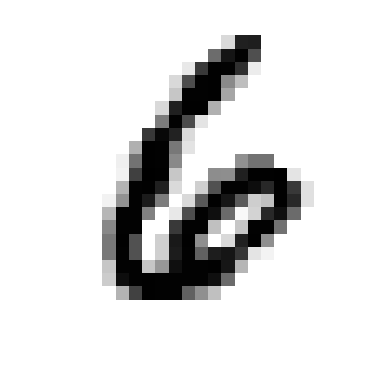

In [ ]:
y_train_6 = (y_train == '6')
y_test_6 = (y_test == '6')
digit_6_example = X[13]
plot_digit(digit_6_example)

## Stochastic gradient descent classifier (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([digit_6_example])

array([ True])

## Measure Performance

### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring='accuracy')
# Not a good measure for a skewed data set (it's only 10% 6's vs 90% non-6's)

array([0.9829 , 0.98025, 0.9804 ])

Implement custom cross validation

In [ ]:
def custom_cross_val_score(model, X_train, y_train, cv, shuffle=False):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.base import clone

  skfolds = StratifiedKFold(n_splits=cv, shuffle=shuffle)
  for train_index, test_index in skfolds.split(X_train, y_train):
    clone_model = clone(model)
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_model.fit(X_train_fold, y_train_fold)
    y_pred = clone_model.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


In [ ]:
custom_cross_val_score(sgd_clf, X_train, y_train_6, 3)

0.9829
0.98025
0.9804


### Confusion Matrix

The idea is to count the number of times instances of class A are classified as class B, for all A/B pairs.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_6, y_train_pred)
cm

# rows - actual classes
# columns - predicted classes

# 1 row - true negatives TN, false positives FP (type I errors)
# 2 row - false positives FP (type II errors), true negatives TN

array([[53562,   520],
       [  609,  5309]])

**Precision** - accuracy of positive predictions  
$\text{precision} = \frac{TP}{TP + FP}$

**Recall** (sensitivity, true positive rate - TPR) - ratio of correctly detected positive instances  
$\text{recall} = \frac{TP}{TP + FN}$

**Specificity** (true negative rate - TNR) - ratio of correctly detected negative instances  
$\text{specificity} = \frac{TN}{TN + FP}$

**Fall-out** (false positive rate, FPR) - ratio of negative instances incorrectly classified as positives  
$\text{fall-out} = 1 - \text{specificity} = \frac{FP}{TN + FP}$

**$F_1$ score** - harmonic mean of precision and recall  
$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(str.format("Precision: {:.2f}", precision_score(y_train_6, y_train_pred)))
print(str.format("Recall: {:.2f}", recall_score(y_train_6, y_train_pred)))
print(str.format("F1 score: {:.2f}", f1_score(y_train_6, y_train_pred)))

Precision: 0.91
Recall: 0.90
F1 score: 0.90


### Choosing Decision Threshold

#### Threshold Curves

In [ ]:
y_scores = sgd_clf.decision_function([digit_6_example])

# default value for SGD classifier
threshold = 0
y_pred = (y_scores > threshold)
y_pred

array([ True])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method='decision_function')

y_train_7 = (y_train == '7')
y_scores_7 = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3, method='decision_function')

y_train_5 = (y_train == '5')
y_scores_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

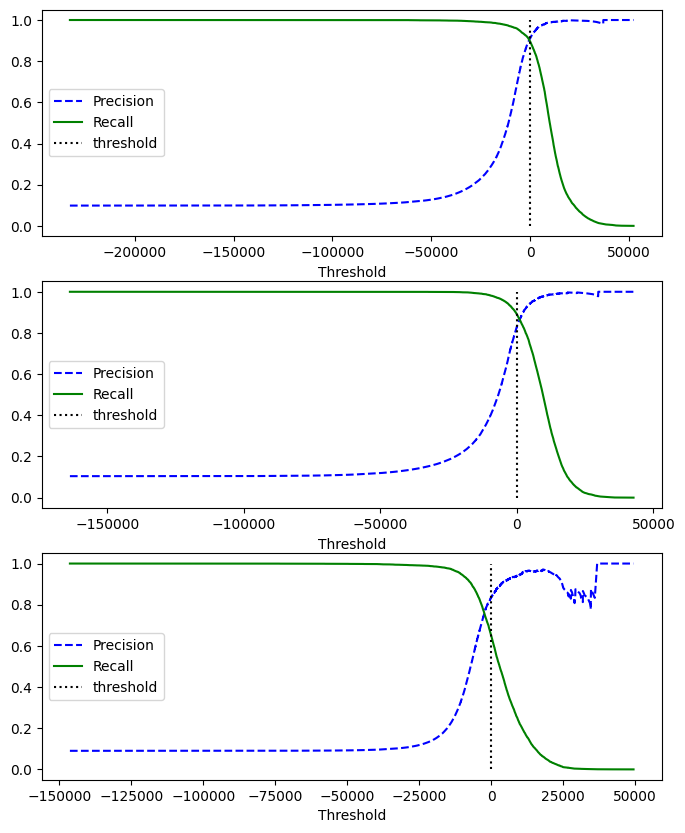

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)
precisions_7, recalls_7, thresholds_7 = precision_recall_curve(y_train_7, y_scores_7)
precisions_5, recalls_5, thresholds_5 = precision_recall_curve(y_train_5, y_scores_5)

plt.figure(figsize=(8, 10)) # in inches

# Draw 6-plot on the left
plt.subplot(3, 1, 1)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='threshold')
plt.xlabel('Threshold')
plt.legend(loc='center left')


# Draw 7-plot in the middle
plt.subplot(3, 1, 2)
plt.plot(thresholds_7, precisions_7[:-1], 'b--', label='Precision')
plt.plot(thresholds_7, recalls_7[:-1], 'g-', label='Recall')
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='threshold')
plt.xlabel('Threshold')
plt.legend(loc='center left')

# Draw 5-plot on the right
plt.subplot(3, 1, 3)
plt.plot(thresholds_5, precisions_5[:-1], 'b--', label='Precision')
plt.plot(thresholds_5, recalls_5[:-1], 'g-', label='Recall')
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='threshold')
plt.xlabel('Threshold')
plt.legend(loc='center left')

plt.show()

#### Precision-Recall Curve

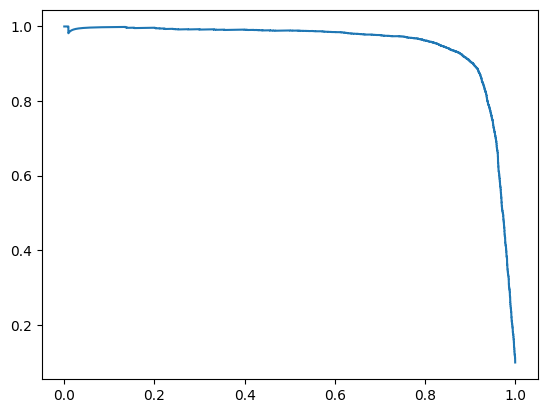

In [ ]:
plt.plot(recalls, precisions)
plt.show()

In [ ]:
# Reach at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(str.format("Precision: {}", precision_score(y_train_6, y_train_pred_90)))
print(str.format("Recall: {}", recall_score(y_train_6, y_train_pred_90)))

Precision: 0.9000670690811536
Recall: 0.9070631970260223


In [ ]:
# Reach at least 95% precision
# (will get lower recall)
threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]
y_train_pred_95 = (y_scores >= threshold_95_precision)

print(str.format("Precision: {}", precision_score(y_train_6, y_train_pred_95)))
print(str.format("Recall: {}", recall_score(y_train_6, y_train_pred_95)))

Precision: 0.9501443695861406
Recall: 0.834065562690098


#### ROC Curve

ROC - receiver operation charactetistic - plot true positive rate against false positive rate (recall against fall-out)

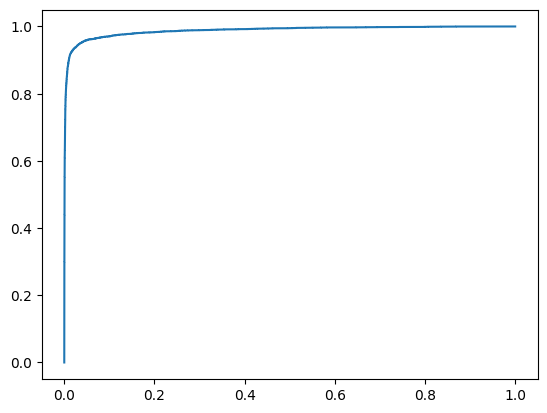

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

plt.plot(fpr, tpr)
plt.show()

**AUC** - area under the curve, perfect classifier has AUC = 1

In [ ]:
from sklearn.metrics import roc_auc_score

print(str.format("ROC AUC score: {:.2f}", roc_auc_score(y_train_6, y_scores)))

ROC AUC score: 0.99


Positive class is rare or care more about false positives - *use RP curve*  
Otherwise - *use ROC curve*

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_6, cv=3, method='predict_proba')
y_probas_forest[:2]

array([[1., 0.],
       [1., 0.]])

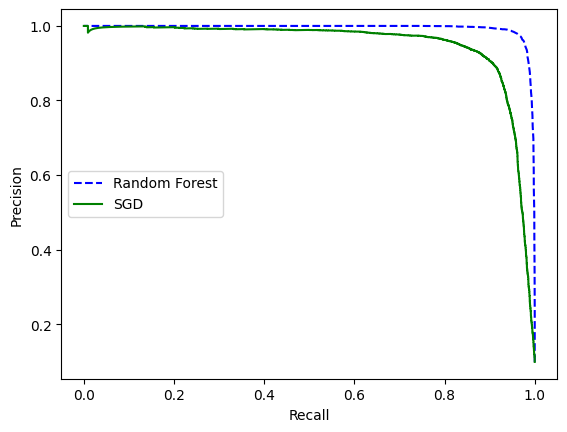

SGD - Random Forest
Precision: 0.91079 - 0.98985
Recall: 0.89709 - 0.93934
F1 score: 0.90389 - 0.96393


In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_6, y_scores_forest)

# Plot both SGD and Random Forest PR curves on the same plot
plt.plot(recalls_forest, precisions_forest, 'b--', label='Random Forest')
plt.plot(recalls, precisions, 'g-', label='SGD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='center left')
plt.show()

y_train_pred_forest = y_probas_forest[:, 1] > 0.5

print("SGD - Random Forest")
print(str.format("Precision: {:.5f} - {:.5f}", precision_score(y_train_6, y_train_pred), precision_score(y_train_6, y_train_pred_forest)))
print(str.format("Recall: {:.5f} - {:.5f}", recall_score(y_train_6, y_train_pred), recall_score(y_train_6, y_train_pred_forest)))
print(str.format("F1 score: {:.5f} - {:.5f}", f1_score(y_train_6, y_train_pred), f1_score(y_train_6, y_train_pred_forest)))

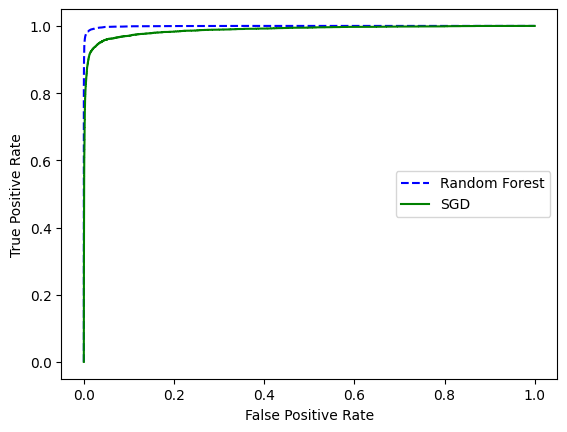

SGD - Random Forest
ROC AUC score: 0.98787 - 0.99916


In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6, y_scores_forest)

# Plot both SGD and Random Forest ROC curves on the same plot
plt.plot(fpr_forest, tpr_forest, 'b--', label='Random Forest')
plt.plot(fpr, tpr, 'g-', label='SGD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center right')
plt.show()

print("SGD - Random Forest")
print(str.format("ROC AUC score: {:.5f} - {:.5f}", roc_auc_score(y_train_6, y_scores), roc_auc_score(y_train_6, y_scores_forest)))

# Multiclass Classification

Some classifiers are **multiclass (multinomial)** natively - LogisticRegression, RandomForestClassifier, GaussianNB  
Others are strictly binary - SGDClassifier, SVC

**One-versus-the-rest (OvR)** strategy (one-versus-all - OvA) - train train binary classifier for each class (N) and take value with *highest score* - less classifiers - usually preffered  
**One-versus-one (OvO)** strategy - train binary classifier for every pair of classes (N x (N - 1) / 2) and take the class which *wins most duels* -  more classifiers, but smaller training sets

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([digit_6_example])

array(['6'], dtype=object)

In [ ]:
digit_6_example_scores = svm_clf.decision_function([digit_6_example])
digit_6_example_scores.round(2)

array([[ 2.78, -0.29,  7.24,  0.72,  8.27,  5.05,  9.31,  1.74,  3.82,
         6.1 ]])

## Error Analysis - Confusion Matrix

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:2000], y_train[:2000], cv=3)

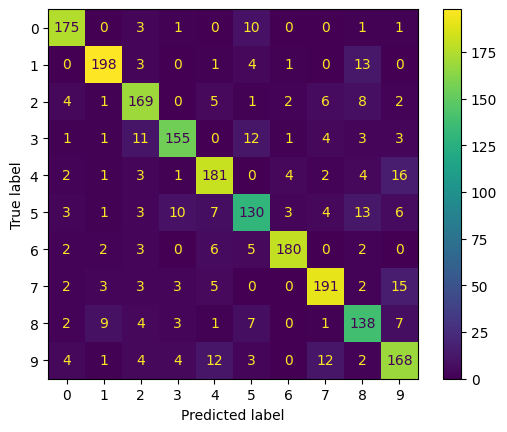

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred)
plt.show()

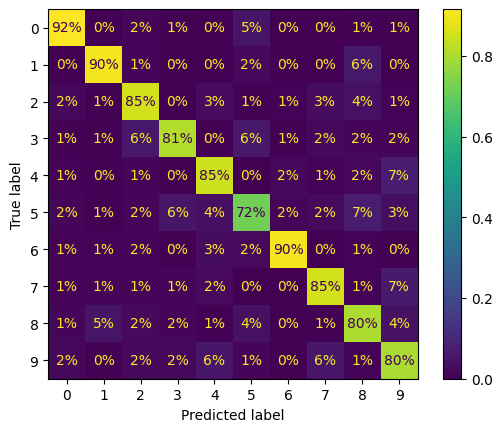

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, normalize="true", values_format=".0%")
plt.show()

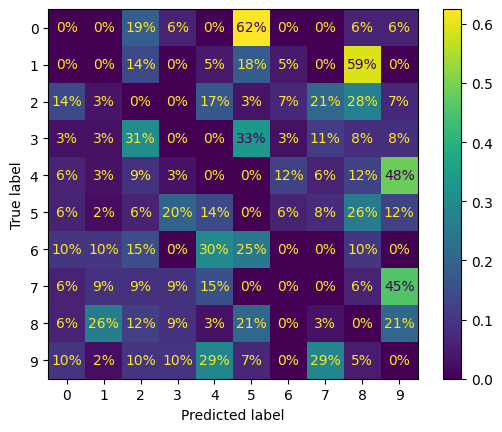

In [ ]:
sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()

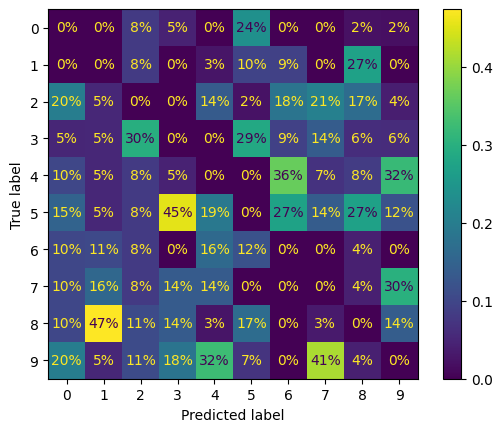

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")
plt.show()

# Multilabel Classification + Multioutput Classification